In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Conv1D, Masking, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### Importo il dataset

In [2]:
file_train= pd.read_csv('df_train.csv')

In [3]:
file_train.shape
file_train

,title,selftext,category_1
0,I want my voice &amp; recordings to sound like...,I'd like to record lines and calls for a pinba...,profession
1,"Jaime Nava, spanish national team captain, pos...","""Some links to spanish captain's opinion after...",sports
2,INAN for a social gathering website,I am building (yet another) social network web...,advice/question
3,WTW for when you're afraid to let yourself lik...,I automatically have to think of a justificati...,advice/question
4,song name?,"""i know the lyrics, but when i google it, i ca...",advice/question
...,...,...,...
226795,[English&gt;German] Need help translating this...,Here is the text:<lb><lb>Company shall be enti...,advice/question
226796,A question about if: stopping the code,"""So i have made this code<lb><lb> temperatu...",programming
226797,Does anyone else miss this subreddit pre Starboy?,"Posts would be random cool shit, we would talk...",music
226798,Lorelai overreacting in 2x19,I'm rewatching the series and I'm up to the ep...,tv_show


#### Preprocessing e pulizia del testo 

In [4]:
# Unisco i file di delle colonne selftext & title
file_train['text']= file_train['title']+ ' ' + file_train['selftext']

In [5]:
pattern = r'\b[a-zA-Z0-9]\b'
file_train['text']= file_train['text'].apply(lambda x: re.sub(pattern, ' ', x))

In [6]:
#Elimino le parole composte da 2 lettere
pattern2 = r'\b(?:\d{2,}|\b\w{2}\b|)\b'
file_train['text']= file_train['text'].apply(lambda x: re.sub(pattern2, ' ', x))

In [7]:
regex_caratteri_speciali = r'[^a-zA-Z0-9\s]'
regex_emoticon = '[^\w\s]'

#Rimuovi i caratteri speciali ed emoticon dalla colonna
file_train['text'] = file_train['text'].apply(lambda x: re.sub(regex_caratteri_speciali, ' ', str(x)))
file_train['text'] = file_train['text'].apply(lambda x: re.sub(regex_emoticon, ' ', str(x)))

In [8]:
# Elimino i spazi 
parole_da_eliminare2 = ['  ','   ','    ','     ','     ','       ']
for parola in parole_da_eliminare2:
    file_train['text'] = file_train['text'].str.replace(parola, ' ', regex=True)


In [9]:
file_train['text'] = file_train['text'].str.strip()
file_train['text'] = file_train['text'].values.tolist()
file_train['text']

0         want voice  amp  recordings sound  like Squawk...
1         Jaime  Nava  spanish  national  team  captain ...
2         INAN  for social  gathering  website  building...
3         WTW  for  when  you afraid let  yourself  like...
4         song  name  know  the  lyrics  but  when googl...
                                ...                        
226795    English German  Need  help  translating  this ...
226796    question  about  stopping  the  code   have  m...
226797    Does  anyone  else  miss  this  subreddit  pre...
226798    Lorelai  overreacting 2x19  rewatching  the  s...
226799    Intro  From  the  ground  down  under  Out the...
Name: text, Length: 226800, dtype: object

In [10]:
df_batch = file_train

#### Tokenizzazione delle categorie e del testo 

In [12]:
num_max = 50000


#Sfrutto il LabelEncoder di ScikitLearn per tokenizzare le classi
le = LabelEncoder()
categorie = le.fit_transform(df_batch['category_1'])
categorie = tf.keras.utils.to_categorical(categorie, num_classes=14)

#Tokenizzo i dati con il Tokenizer di Keras
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_max)
tokenizer.fit_on_texts(df_batch['text'])
parole = tokenizer.texts_to_sequences(df_batch['text'])

max_len = 861


print(categorie[:5])
print(parole[:5],max_len)
print(categorie.shape)


[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[42, 680, 110, 5686, 398, 16, 38911, 2, 354, 3058, 653, 16, 802, 858, 2, 1205, 3, 23268, 547, 6, 42, 3058, 398, 16, 285, 23, 23268, 594, 143, 1, 580, 15439, 12, 723, 49, 23, 3, 165, 61, 37, 30, 660, 2439, 35, 3058, 653, 55, 21, 158, 26, 72, 23268, 2186, 890, 4141, 876, 4996, 14920, 2198, 10261, 2, 94, 426, 84, 1, 3058, 653, 55, 21, 409, 38911, 2, 354, 21, 57, 77, 72, 23268, 2186, 354, 1, 505], [14561, 40548, 2296, 1795, 284, 3270, 160, 796, 917, 2, 9077, 16450, 354, 63, 1, 120, 26, 1234, 2296, 3270, 765, 63, 1, 120, 2, 51, 9077, 16450, 354, 51, 2296, 375, 1, 33, 312, 17705, 542, 351, 20, 1, 1977, 160, 796, 917, 59, 128, 45, 14561, 40548, 44598, 4296, 4207, 741, 9792, 53, 7, 2296, 1795, 4296, 284, 14561, 40548, 254, 8056, 434, 1, 1657, 1168, 270, 2022, 434, 5784, 

In [13]:
print(len(parole))

226800


In [14]:
print(df_batch['text'][5])
print(parole[5])

Best  practice  for  storing  user  session  was  wondering  what  the  current  best  practices  are  for  storing  user  sessions  after  being  authenticated   seen number people  talk  about  using  contexts  but  since  experimental  still don want necessarily  put  all eggs that  basket   also  tried  simply  storing  state  and  passing   props  where  needed  but  that  got  messy  quickly  Right  now seem use  browser  Local  Storage solution  but  not  sure this the  best  approach   ultimately  there  best  practice for  this  currently  Thanks advance  for  any  help
[132, 654, 3, 4797, 322, 1446, 10, 217, 15, 1, 372, 132, 3299, 13, 3, 4797, 322, 2807, 63, 91, 15043, 286, 350, 60, 354, 20, 107, 16308, 6, 103, 6103, 86, 37, 42, 2488, 199, 18, 4942, 4, 7011, 48, 179, 661, 4797, 486, 2, 2268, 4183, 78, 474, 6, 4, 82, 4605, 811, 99, 41, 261, 79, 1502, 458, 1199, 681, 6, 11, 116, 5, 1, 132, 1214, 2574, 22, 132, 654, 3, 5, 224, 84, 342, 3, 24, 49]


#### Aggiunta del Padding al testo

In [16]:
parole_inputs = pad_sequences(parole, maxlen=861)
print(parole_inputs[5])
print('')


[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [17]:
print(parole_inputs.shape)

(226800, 861)


#### Divisione del testo in Train (80% del dataset) e Test (20% del dataset)

In [18]:
parole_train, parole_val, categorie_train, categorie_val = train_test_split(parole_inputs, categorie, test_size=0.2, random_state=42)

#### Creazione del Transformer e del Embedding

In [19]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__ (self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation = 'relu'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-8)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-8)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training= training)
        out1= self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim = vocab_size, output_dim= embed_dim)
        self.pos_emb = layers.Embedding(input_dim= max_len, output_dim = embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions= self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

#### Scrittura del'architettura e compilazione del modello 

In [23]:
from tensorflow import keras 
embed_dim = 50
num_heads = 1
ff_dim = 512
vocab_size = 50000

inputs = layers.Input(max_len,)
x = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(ff_dim, activation='swish')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation = 'softmax')(x)

model = keras.Model(inputs=inputs, outputs= outputs)

In [24]:
model.compile(optimizer = Adam(learning_rate=0.001) , loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())

#### Addestramento del modello 

In [25]:
history = model.fit(
    parole_train,
    categorie_train,
    batch_size = 25,
    epochs= 5,
    validation_data = (parole_val, categorie_val)
)

Epoch 1/5
7258/7258 [==============================] - 4549s 626ms/step - loss: 1.1193 - categorical_accuracy: 0.6519 - val_loss: 0.7532 - val_categorical_accuracy: 0.8206
Epoch 2/5
7258/7258 [==============================] - 4729s 652ms/step - loss: 0.5347 - categorical_accuracy: 0.8545 - val_loss: 0.6685 - val_categorical_accuracy: 0.8342
Epoch 3/5
7258/7258 [==============================] - 4619s 636ms/step - loss: 0.3966 - categorical_accuracy: 0.8937 - val_loss: 0.6652 - val_categorical_accuracy: 0.8457
Epoch 4/5
7258/7258 [==============================] - 4782s 659ms/step - loss: 0.3001 - categorical_accuracy: 0.9203 - val_loss: 0.7906 - val_categorical_accuracy: 0.8454
Epoch 5/5
7258/7258 [==============================] - 4794s 660ms/step - loss: 0.2341 - categorical_accuracy: 0.9375 - val_loss: 0.8221 - val_categorical_accuracy: 0.8404


#### Risultati di addestramento 

In [27]:
test_score = model.evaluate(parole_train, categorie_train)
print(test_score)
print(model.metrics_names)
print('test metrics: {} {:.4f}, {} {:.2f}%'.format(
    model.metrics_names[0],
    test_score[0],
    model.metrics_names[1],
    test_score[1] * 100
) 
     )

5670/5670 [==============================] - 1754s 309ms/step - loss: 0.1347 - categorical_accuracy: 0.9657
[0.1346626579761505, 0.9656911492347717]
['loss', 'categorical_accuracy']
test metrics: loss 0.1347, categorical_accuracy 96.57%


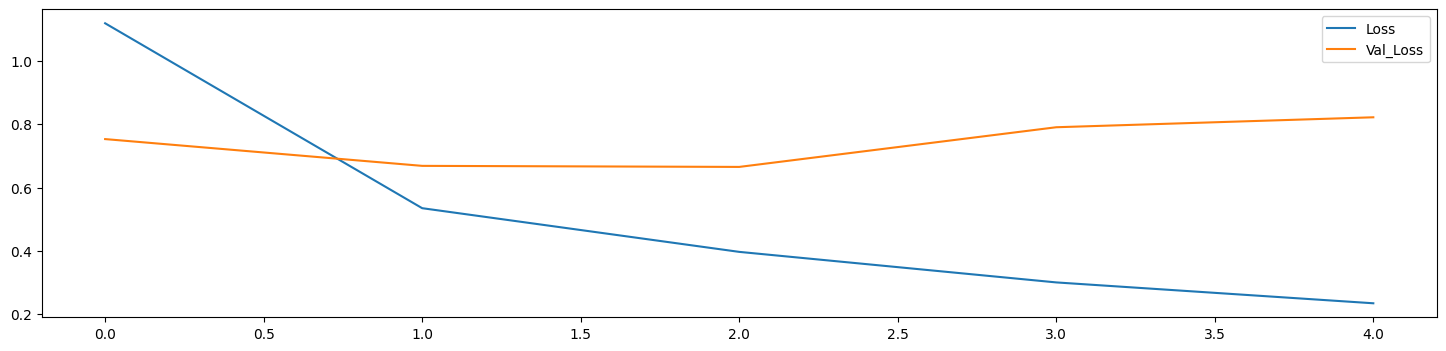

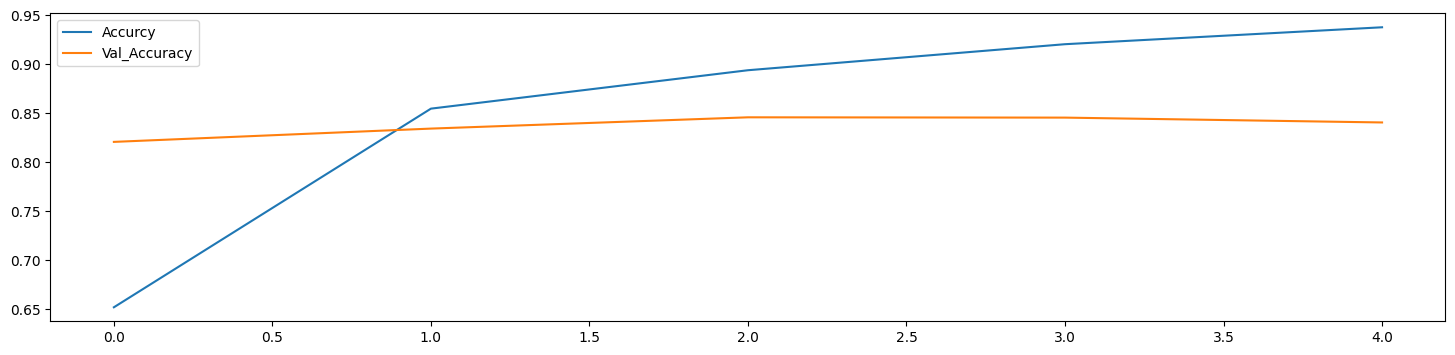

In [33]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history.history['categorical_accuracy'], label='Accurcy')
plt.plot(history.history['val_categorical_accuracy'], label='Val_Accuracy')
plt.legend()
plt.show()

#### Importo il dataset di test per effettuare le previsioni

In [34]:
input_test = pd.read_csv('df_test.csv')
input_test

,title,selftext
0,[PI]Of Supreme Importance,"""""""My... what?""""<lb><lb>""""Zombie survival plan..."
1,“Frankly there is absolutely no collusion…Virt...,"""Quote in full:<lb><lb>""""Frankly there is abso..."
2,Hello everyone.. Can you help me to fill this ...,"So, I have an assignment to write an essay abo..."
3,Need some plex help for ultraseedbox,"""Hello,<lb>I wanted to reach out to reddit for..."
4,When should you give up?,Is there a point when you just know bass (or a...
...,...,...
25195,Just whining + maybe I‘m just lesbian idk + ho...,"Hey there, <lb>sorry in advance, I can‘t help ..."
25196,Specific Tourist outfit.,As I’ve written here before I will be spending...
25197,What is the story behind McAdoo?,Everyone in the warriors bench has either pote...
25198,Just a few noob questions,Please forgive poor formatting I'm on mobile.<...


#### Effettuo lo stesso preprocessing dei dati effetuato sul dataset di train 

In [36]:
# Unisco i file di delle colonne selftext & title
test= pd.DataFrame({
})
test['text']= input_test['title']+ ' ' + input_test['selftext']

In [37]:
pattern = r'\b[a-zA-Z0-9]\b'
test['text']= test['text'].apply(lambda x: re.sub(pattern, ' ', x))

In [38]:
#Elimino le parole composte da 2 lettere
pattern2 = r'\b(?:\d{2,}|\b\w{2}\b|)\b'
test['text']= test['text'].apply(lambda x: re.sub(pattern2, ' ', x))

In [39]:
regex_caratteri_speciali = r'[^a-zA-Z0-9\s]'  
regex_emoticon = '[^\w\s]' 

#Rimuovi i caratteri speciali ed emoticon dalla colonna
test['text'] = test['text'].apply(lambda x: re.sub(regex_caratteri_speciali, ' ', str(x)))
test['text'] = test['text'].apply(lambda x: re.sub(regex_emoticon, ' ', str(x)))

In [40]:
# Elimino i spazi 
parole_da_eliminare2 = ['  ','   ','    ','     ','     ','       ']
for parola in parole_da_eliminare2:
    test['text'] = test['text'].str.replace(parola, ' ', regex=True)

In [41]:
test['text'] = test['text'].str.strip()
test['text'] = test['text'].values.tolist()
test['text']

0        Supreme  Importance  what Zombie  survival  pl...
1        Frankly  there absolutely collusion  Virtually...
2        Hello  everyone Can  you  help   fill  this  q...
3        Need  some  plex  help  for  ultraseedbox  Hel...
4        When  should  you  give   there point  when  y...
                               ...                        
25195    Just  whining maybe  just  lesbian  idk how  d...
25196    Specific  Tourist  outfit  written  here  befo...
25197    What the  story  behind  McAdoo  Everyone the ...
25198    Just few  noob  questions  Please  forgive  po...
25199    What you  guys  like watch youtube instagram t...
Name: text, Length: 25200, dtype: object

In [44]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_max)
tokenizer.fit_on_texts(test['text'])
parole_test = tokenizer.texts_to_sequences(test['text'])

max_len = 861

print(categorie[:5])
print(parole[:5],max_len)

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[42, 680, 110, 5686, 398, 16, 38911, 2, 354, 3058, 653, 16, 802, 858, 2, 1205, 3, 23268, 547, 6, 42, 3058, 398, 16, 285, 23, 23268, 594, 143, 1, 580, 15439, 12, 723, 49, 23, 3, 165, 61, 37, 30, 660, 2439, 35, 3058, 653, 55, 21, 158, 26, 72, 23268, 2186, 890, 4141, 876, 4996, 14920, 2198, 10261, 2, 94, 426, 84, 1, 3058, 653, 55, 21, 409, 38911, 2, 354, 21, 57, 77, 72, 23268, 2186, 354, 1, 505], [14561, 40548, 2296, 1795, 284, 3270, 160, 796, 917, 2, 9077, 16450, 354, 63, 1, 120, 26, 1234, 2296, 3270, 765, 63, 1, 120, 2, 51, 9077, 16450, 354, 51, 2296, 375, 1, 33, 312, 17705, 542, 351, 20, 1, 1977, 160, 796, 917, 59, 128, 45, 14561, 40548, 44598, 4296, 4207, 741, 9792, 53, 7, 2296, 1795, 4296, 284, 14561, 40548, 254, 8056, 434, 1, 1657, 1168, 270, 2022, 434, 5784, 

In [45]:
parole_inputs = pad_sequences(parole_test, maxlen=861)
print(parole_inputs[18])
print('')

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

#### Creo una nuova colonna nel dataset input_test con le predizioni del modello e salvo il .csv 

In [53]:
input_test['predictions'] = np.expand_dims(np.argmax(model.predict(parole_inputs), axis=1), axis=-1)
input_test['predictions'] = le.inverse_transform(input_test['predictions'])


788/788 [==============================] - 247s 313ms/step


In [54]:
import os as os
filenamepath = os.path.abspath(os.path.join(r'C:\Users\claud\Desktop\Python\reddit', 'submission.csv'))
input_test.to_csv(filenamepath, index=False)

#### Illustrazione del file csv con le previsioni del modello

In [56]:
submission = pd.read_csv('submission.csv')
submission.head() 

,title,selftext,predictions
0,[PI]Of Supreme Importance,"""""""My... what?""""<lb><lb>""""Zombie survival plan...",crypto
1,“Frankly there is absolutely no collusion…Virt...,"""Quote in full:<lb><lb>""""Frankly there is abso...",sports
2,Hello everyone.. Can you help me to fill this ...,"So, I have an assignment to write an essay abo...",crypto
3,Need some plex help for ultraseedbox,"""Hello,<lb>I wanted to reach out to reddit for...",music
4,When should you give up?,Is there a point when you just know bass (or a...,hobby
